# Practical Deep Learning Workshop 2021
## Assignment 2 - Word Embeddings
 
### Authors:
 
1.   Chen Doytshman 205644941
2.   Naor Kolet 205533060


# 0. Imports

In [2]:
import pandas as pd
import numpy as np
 
# TensorFlow
import tensorflow as tf

# Scikit-learn
#from sklearn.

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
import os
import joblib
from tqdm import tqdm_notebook as tqdm

SEED = 42
%matplotlib inline

In [3]:
pd.set_option('display.max_colwidth', 100)

In [4]:
import zipfile
DATA_DIR = 'home-depot-product-search-relevance'

files = [f for f in os.listdir(DATA_DIR) if f.endswith('zip')]
for file in tqdm(files):
    with zipfile.ZipFile(f'{DATA_DIR}/{file}') as zf:
        zf.extractall(DATA_DIR)
        os.remove(f'{DATA_DIR}/{file}')

# 0.1 Data Preparation, EDA

Let's load the data:

In [66]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv', index_col='id', encoding='latin-1')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv', index_col='id', encoding='latin-1')
product_desc_df = pd.read_csv(f'{DATA_DIR}/product_descriptions.csv', index_col='product_uid')
attributes_df = pd.read_csv(f'{DATA_DIR}/attributes.csv', index_col=['product_uid'], dtype={'product_uid': 'Int64'})

In [89]:
train_df.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


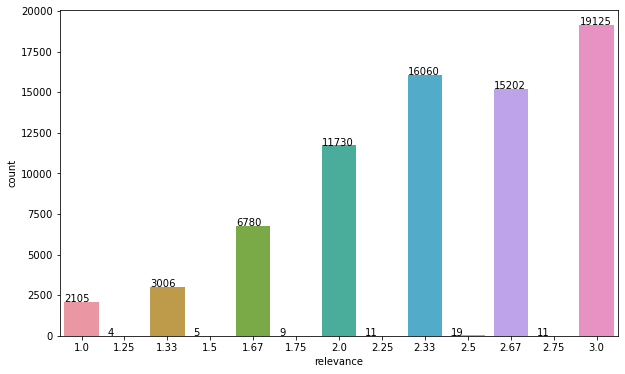

In [90]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=train_df, x="relevance")

relevance_values = train_df["relevance"].value_counts().sort_index()

for p, label in zip(ax.patches, relevance_values):
    ax.annotate(label, (p.get_x(), p.get_height()+0.5))

In [187]:
product_desc_df.head()

,product_description,concat_desc
product_uid,,
100001,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si...",Versatile connector for various 90° connections and home repair projects ; Stronger than angled ...
100002,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, wea...","Application Method Brush,Roller,Spray ; Assembled Depth (in.) 6.63 in ; Assembled Height (in.) 7..."
100003,"Classic architecture meets contemporary design in the Ensemble Curve series, made of solid Vikre...",Built-in flange Yes ; Slightly narrower for tighter spaces ; Designed with an 18 in. apron ; Dur...
100004,The Grape Solar 265-Watt Polycrystalline PV Solar Panel bonus pack bundles 4 Grape Solar 265-Wat...,Amperage (amps) 8.56 ; Positive power tolerance (0 to +5-Watt) ; Anti-reflective and anti-soilin...
100005,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...,"Bath Faucet Type Combo Tub and Shower ; Built-in Water Filter No ; Includes the trim kit only, t..."


In [107]:
product_desc_df.iloc[0, 0]

'Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws'

In [155]:
attributes_df

,name,value
product_uid,,
100001,Bullet01,Versatile connector for various 90° connections and home repair projects
100001,Bullet02,Stronger than angled nailing or screw fastening alone
100001,Bullet03,Help ensure joints are consistently straight and strong
100001,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
100001,Bullet05,Made from 12-Gauge steel
...,...,...
224428,Pilot Bit Included,No
224428,Power Tool Product Type,Drill & Router Bits
224428,Shank Diameter,3/8 in


In [67]:
def concat_attr(record):
    name, value = record
    name = f'{name} ' if not name.startswith('Bullet') else '' # Delete name if it's a "Bullet.."
    return f'{name}{value} ;'

product_groups = attributes_df.groupby('product_uid')
for product_uid, df in product_groups:
    joined_attrs = ' '.join(map(concat_attr, df.values))
    product_desc_df.loc[product_uid, 'concat_desc'] = joined_attrs

In [163]:
product_desc_df

,product_description,concat_desc
product_uid,,
100001,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si...",Versatile connector for various 90° connections and home repair projects ; Stronger than angled ...
100002,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, wea...","Application Method Brush,Roller,Spray ; Assembled Depth (in.) 6.63 in ; Assembled Height (in.) 7..."
100003,"Classic architecture meets contemporary design in the Ensemble Curve series, made of solid Vikre...",Built-in flange Yes ; Slightly narrower for tighter spaces ; Designed with an 18 in. apron ; Dur...
100004,The Grape Solar 265-Watt Polycrystalline PV Solar Panel bonus pack bundles 4 Grape Solar 265-Wat...,Amperage (amps) 8.56 ; Positive power tolerance (0 to +5-Watt) ; Anti-reflective and anti-soilin...
100005,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...,"Bath Faucet Type Combo Tub and Shower ; Built-in Water Filter No ; Includes the trim kit only, t..."
...,...,...
224424,Create a neat yet stylish storage space for organizing bathroom essentials with the stufurhome N...,"Assembly Required No ; Solid wood construction, only the side and backboard is plywood ; DTC sof..."
224425,"Our Bullnose Adirondack Chair Cushions fit Adirondack chairs, loveseats (requires two) and rocke...",Assembled Depth (in.) 49 in ; Assembled Height (in.) 2 in ; Assembled Width (in.) 20.5 in ; Resi...
224426,"Joist hangers are designed to provide support underneath the joist, rafter or beam to provide a ...",NaN


TODO: explain the connection between description and attributes

In [68]:
train_df = train_df.join(product_desc_df['product_description'], on='product_uid')
train_df['product_description'] = train_df['product_title'] + ' : ' + train_df['product_description']
train_df = train_df[['product_uid', 'search_term', 'product_description', 'relevance']]

In [69]:
def tokenize_df(search_col, desc_col):
    tokenized_search = pd.Series(map(lambda x: ' '.join(list(x)), search_col.values), index=search_col.index)
    tokenized_desc = pd.Series(map(lambda x: ' '.join(list(x)), desc_col.values), index=desc_col.index)
    return tokenized_search, tokenized_desc
    
train_df['search_term'], train_df['product_description']  = tokenize_df(train_df['search_term'], train_df['product_description'])

In [54]:
pd.Series(map(lambda x: ' '.join(list(x)), train_df.iloc[30:40:, :]['search_term'].values))

0                      s a m s u n g   f r o n t   l o a d   w a s h e r   3 . 7
1    u p h o l s t e r y   w a s h i n g   m a c h i n e s   w i t h   s t e a m
2          C O N C R E T E   &   M A S O N R Y   C L E A N E R   &   E T C H E R
3                                            c o n c r e t e   f o r   p o n d s
4                                          f l e x l o c k   f o r   c r a c k s
5                                        B e l g i u m   b l o c k   p a v e r s
6                                            o u r d o o r   p a t i o   t i l e
7                                                  i n s u l a t i o n   r o l l
8                                        6 f t   h   b a m b o o   f e n c i n g
9                                    b a l c o n y   p r i v a c y   s c r e e n
dtype: object

In [21]:
next(map(lambda x: ' '.join(list(x)), train_df.iloc[:20, :]['search_term'].values))

'a n g l e   b r a c k e t'

In [70]:
train_df

,product_uid,search_term,product_description,relevance
id,,,,
2,100001,a n g l e b r a c k e t,S i m p s o n S t r o n g - T i e 1 2 - G a u g e A n g l e : N o t o n l y d o ...,3.00
3,100001,l b r a c k e t,S i m p s o n S t r o n g - T i e 1 2 - G a u g e A n g l e : N o t o n l y d o ...,2.50
9,100002,d e c k o v e r,B E H R P r e m i u m T e x t u r e d D e c k O v e r 1 - g a l . # S C - 1 4 1 T u ...,3.00
16,100005,r a i n s h o w e r h e a d,D e l t a V e r o 1 - H a n d l e S h o w e r O n l y F a u c e t T r i m K i t ...,2.33
17,100005,s h o w e r o n l y f a u c e t,D e l t a V e r o 1 - H a n d l e S h o w e r O n l y F a u c e t T r i m K i t ...,2.67
...,...,...,...,...
221457,206638,t v r i s e r g l a s s,A t l a n t i c W i n d o w p a n e 5 7 6 C D o r 1 9 2 D V D B l u - R a y o r ...,1.00
221458,206639,r 2 0 h a l o g e n l i g h t,P h i l i p s 4 0 - W a t t H a l o g e n R 2 0 F l o o d L i g h t B u l b ( 1 2 ...,3.00
221463,206641,s c h l a g e l o c k s i e n a h a l f d u m m y k n o b w i t h,S c h l a g e C a m e l o t I n - A c t i v e A g e d B r o n z e H a n d l e s e t ...,2.33


# Character level LSTM

## 1. Using character level processing to predict search relevance

TODO: explain the replacement of items' description column